# La segmentation d'image
## Travail réalisé par :
<html>
<ul>
<h3>
<li>Ahmed Bellaaj
<li>Omar Chaabouni
<li>Chaima Araibi
</ul>
</html>

### Introduction :
Le traitement d'images joue aujourd'hui un rôle important dans de nombreux domaines.
Dans un système de traitement d’images, l’opération la plus importante est la segmentation d’image. Jusqu’à ce jour, il n’existe pas de méthode universelle de segmentation d’image.
Toute technique n’est efficace que pour un type d’image donné, pour un type d’application donné, et dans un contexte informatique donné.
La segmentation d’image est une operation de traitement d’images qui a pour but de rassembler des pixels entre eux suivant des critéres pre-definis. Les pixels sont ainsi regroupes en regions, qui constituent une partition de l’image. Il peut s’agir par exemple de separer les objets du fond. 
<hr>

### Etat de l'art :
La segmentation est une étape primordiale en traitement d'image. À ce jour, il existe de nombreuses méthodes de segmentation, que l'on peut regrouper en quatre principales classes :
<ol>
<li>La segmentation fondée sur les régions (en anglais : region-based segmentation). On y trouve par exemple : la croissance de région (en anglais : region-growing), décomposition/fusion (en anglais : split and merge).
<li>La segmentation fondée sur les contours (en anglais : edge-based segmentation).
<li>La segmentation fondée sur la classification ou le seuillage des pixels en fonction de leur intensité (en anglais : classification ou thresholding).
<li>La segmentation fondée sur la coopération entre les trois premières segmentations.
</ol>
Pour étre cohérent avec le contenu du cours on va nous intéresser avec les approches orientées histogramme et celles orientées régions 


### Travail réalisé :
#### 1. Importer les librairies et bibliothéques nécessaires

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.filters import threshold_otsu,threshold_multiotsu
from skimage.transform import resize
import cv2
import pandas as pd
from sklearn.cluster import KMeans

#### 2.Charger les images et les vérités terrain à partir du dossier Datasets
Nous avons opter pour travailler sur les datasets suivantes : 
* 1objet
* 2objets
* cellules
* textfort <br>
==> ca fait 60 images au total

In [22]:
path = os.getcwd()
img_path = path+"\Datasets\images"
verite_path = path+"\Datasets\\verite_terrain"
sub_folders = os.listdir(img_path)

# charger les images d'un dossier images
def load_dataset_content(x):
    objet= []
    for i in os.listdir(img_path+"\\"+sub_folders[x]):
        if i!="Thumbs.db":
            img = imread(os.path.join(img_path+"\\"+sub_folders[x], i ), as_gray=True)
            objet.append(img) 
    return objet

# charger les images d'un dossier vérité terrain
def load_terrain(x):
    objet= []
    for i in os.listdir(verite_path+"\\"+sub_folders[x]):
        if i!="Thumbs.db":
            img = imread(os.path.join(verite_path+"\\"+sub_folders[x], i ), as_gray=True)
            objet.append(img) 
    return objet

# changer la taille des images vérité terrain vers la taille de leur homologue dans le dossier image
def fix_size(imgs,verites):
    for i in range(len(imgs)):
        if verites[i].shape != imgs[i].shape :
            verites[i] = resize(verites[i], (imgs[i].shape[0], imgs[i].shape[1]),anti_aliasing=True)
    return verites
        
    

In [23]:
objet = load_dataset_content(0)
vobjet = load_terrain(0)
vobjet=fix_size(objet,vobjet)
objets = load_dataset_content(1)
vobjets = load_terrain(1)
vobjets=fix_size(objets,vobjets)
cellules = load_dataset_content(3)
vcellules = load_terrain(3)
vcellules = fix_size(cellules,vcellules)
textfort = load_dataset_content(4)
vtextfort = load_terrain(4)
#vtextfort = fix_size(textfort,textfort)

#### 3.Affichage des images et des verités terrains pour chaque base :
Cela permet de prendre une idée préliminaire sur la nature des images et les meilleures méthodes que nous pouvons appliquer
##### Nous ecrivons la méthode suivante pour obtenir l'affichage d'une maniére modulaire

In [24]:
# afficher les images et les bases
def display(dataset , vdataset):
    fig, axes = plt.subplots(len(dataset),2 ,figsize=(20, 20))
    ax = axes.ravel()
    for i in range(0,(len(dataset)*2),2):
        j=i//2
        ax[i].imshow(dataset[j], cmap=plt.cm.gray)
        ax[i].axis('off')
        ax[i+1].imshow(vdataset[j], cmap=plt.cm.gray)
        ax[i+1].axis('off')
    fig.tight_layout()
    plt.show()

# afficher les images , les sorties des deux méthodes de segmentation et les images de base pour chaque dossier    
def display_after_seg(dataset , vdataset , m1 , m2):
    fig, axes = plt.subplots(len(dataset),4 ,figsize=(20, 20))
    ax = axes.ravel()
    for i in range(0,(len(dataset)*4),4):
        j=i//4
        ax[i].imshow(dataset[j], cmap=plt.cm.gray)
        ax[i].axis('off')
        ax[i+1].imshow(vdataset[j], cmap=plt.cm.gray)
        ax[i+1].axis('off')
        ax[i+2].imshow(m1[j], cmap=plt.cm.gray)
        ax[i+2].axis('off')
        ax[i+3].imshow(m2[j], cmap=plt.cm.gray)
        ax[i+3].axis('off')
    fig.tight_layout()
    plt.show()

##### a.Pour les images de 1objet :

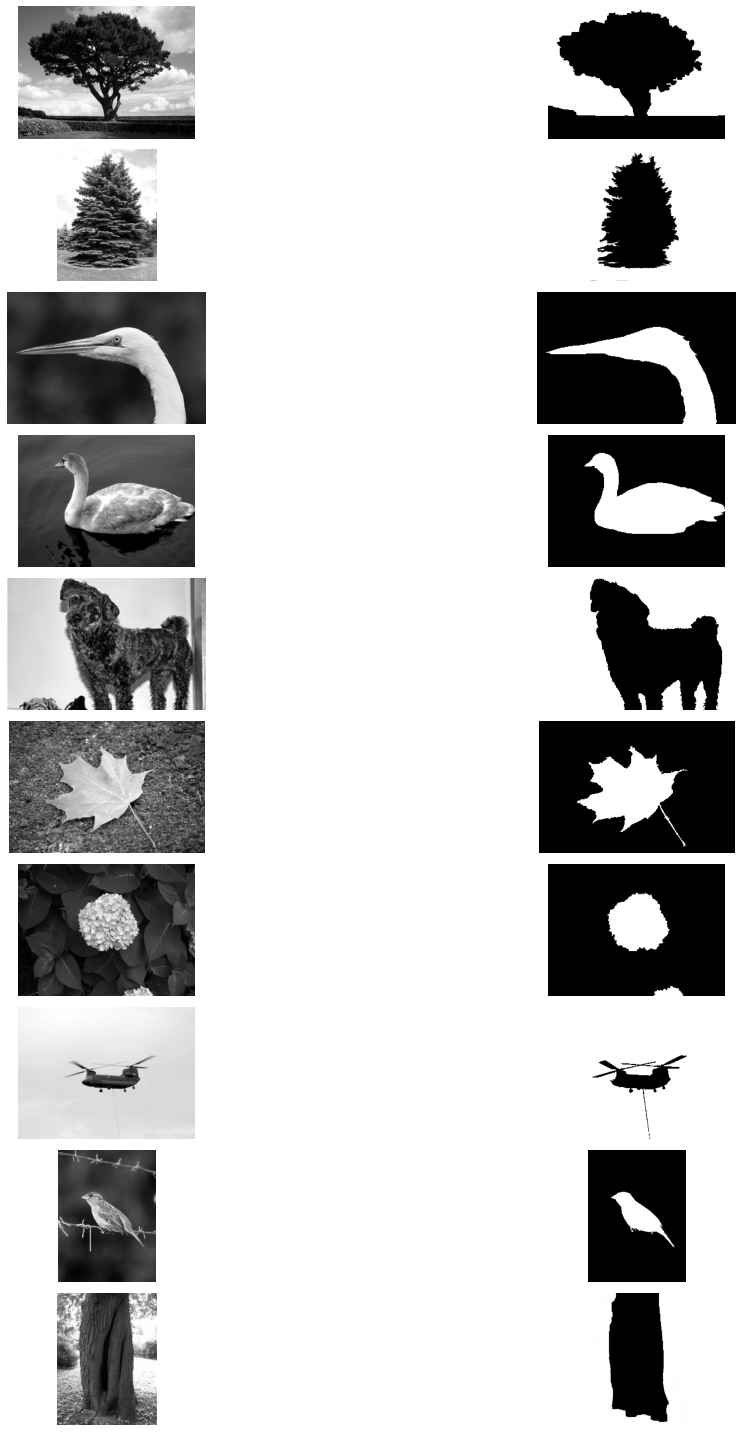

In [25]:
display(objet,vobjet)

##### b.Pour les images de 2objets :

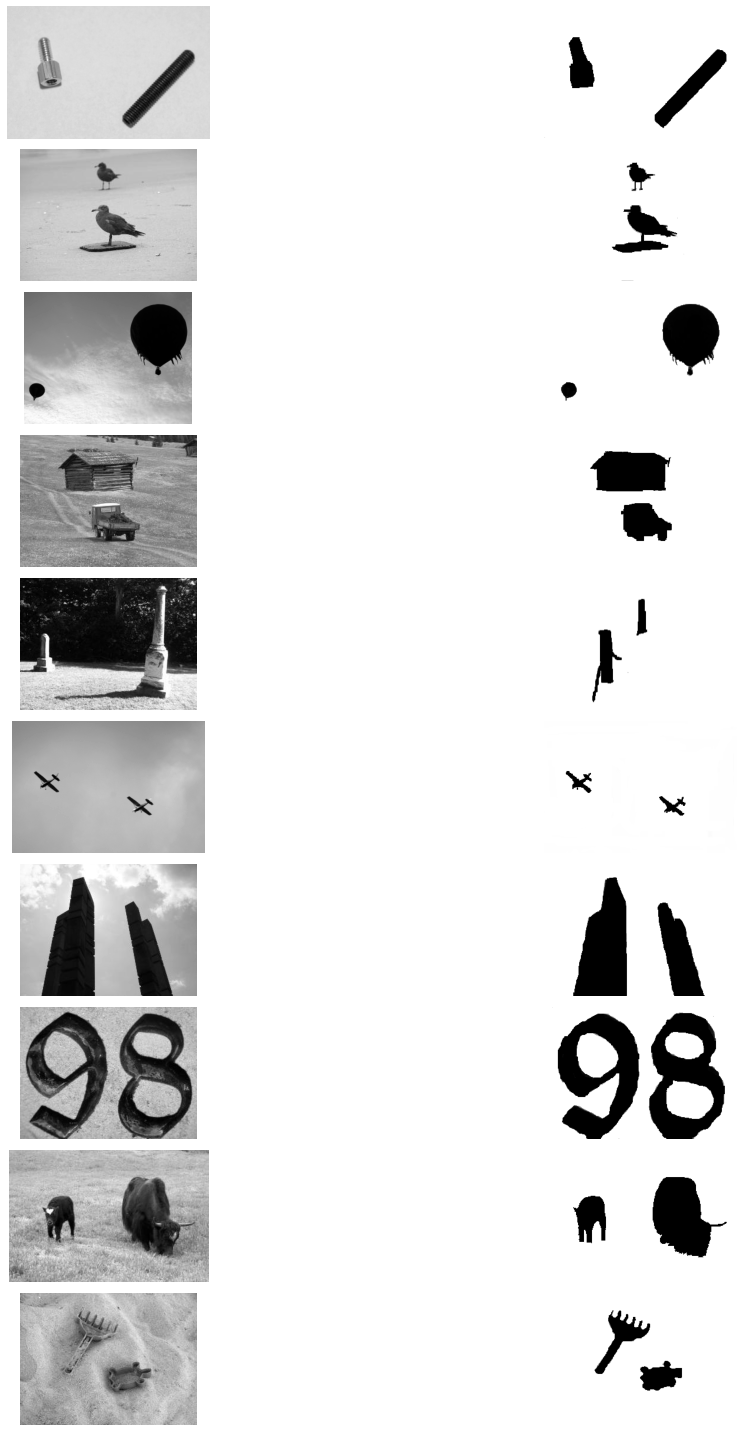

In [26]:
display(objets,vobjets)

##### c.Pour les images de cellules :

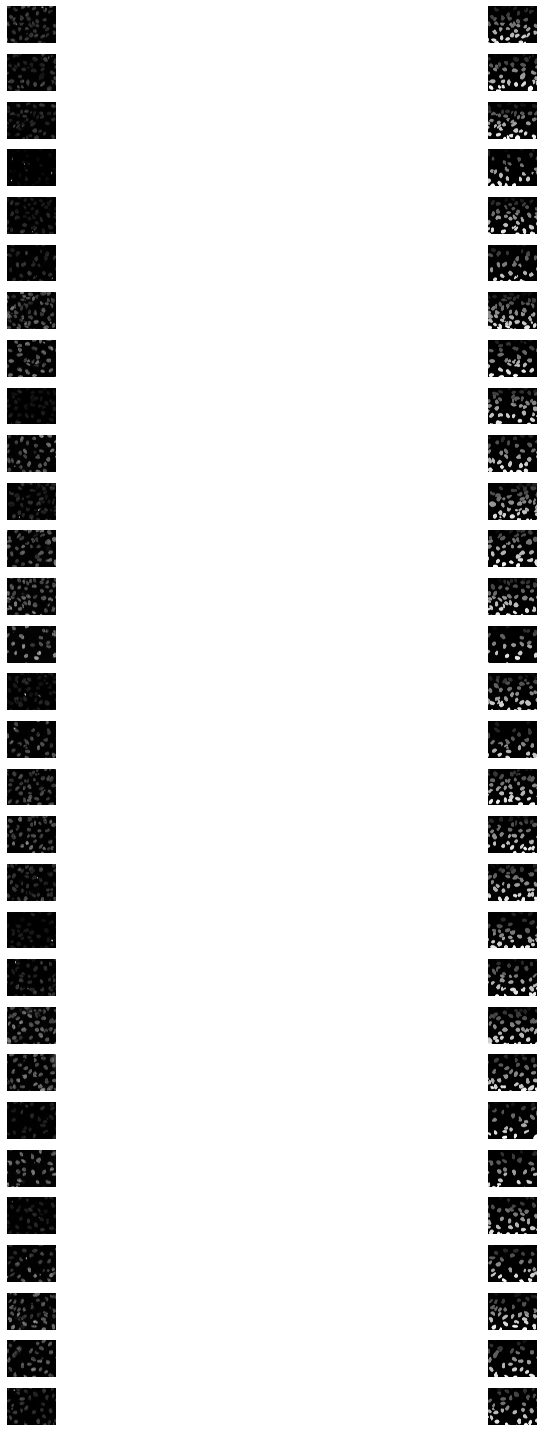

In [27]:
display(cellules,vcellules)

##### d.Pour les images de textfort :

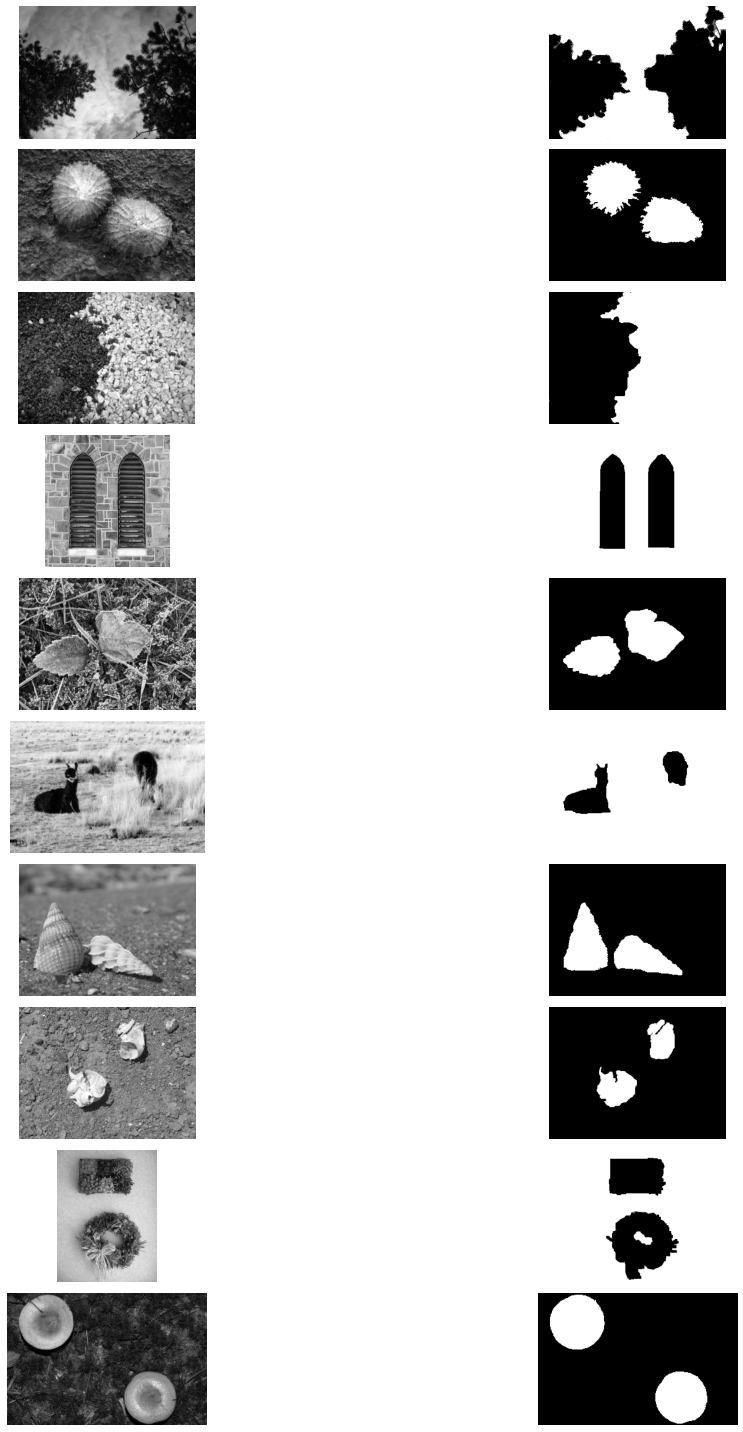

In [28]:
display(textfort,vtextfort)

#### 3.Choix des méthodes de segmentation
Pour réaliser la segmentation , on va faire recours à deux méthodes qui sont:
<ol>
    <li>Segmentation par seuillage d'histogramme (OTSU)
    <li>Segmentation par classification (Algorithme KNN)
</ol>

##### Segmentation par seuillage d'histogramme (OTSU) :
En vision par ordinateur et traitement d'image, la méthode d'Otsu est utilisée pour effectuer un seuillage automatique à partir de la forme de l'histogramme de l'image, ou la réduction d'une image à niveaux de gris en une image binaire. L'algorithme suppose alors que l'image à binariser ne contient que deux classes de pixels, (c'est-à-dire le premier plan et l'arrière-plan) puis calcule le seuil optimal qui sépare ces deux classes afin que leur variance intra-classe soit minimale. L'extension de la méthode originale pour faire du seuillage à plusieurs niveaux est appelée Multi Otsu method. Le nom de cette méthode provient du nom de son initiateur, Nobuyuki Otsu (大津展之, Ōtsu Nobuyuki). Elle ne doit pas être confondue avec la méthode d'Antzu.
Dans la méthode d'Otsu, le seuil qui minimise la variance intra-classe est recherché à partir de tous les seuillages possibles.
###### Implémentation :
nous allons nous servir des fonctionnalités de OpenCV qui met à notre dispostion une implémentation de la méthode d'otsu
nous avons aussi implémenté la fonction du seuillage otsu multiclasse et seuillage adaptatif pour les uliliser en cas besoin

In [29]:
def threshold_otsu(img):
    ret2, thresh2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    regions1=np.digitize(img, bins=np.array([ret2]))
    return regions1 


def threshold_multi_otsu(img , classes):
    thresholds = threshold_multiotsu(img , classes=classes)
    # Using the threshold values, we generate the three regions.
    regions = np.digitize(img, bins=thresholds)
    return regions

##### Segmentation par classification (Algorithme KNN) :
L’algorithme des k-moyennes (k-means) est une méthode itérative qui affecte chaque pixel de l’image à l’un des K groupes (clusters)
• K= Nombre de régions à trouver (choisi par l’utilisateur).
Les étapes sont :
1. Choisir un nombre de classes K et placer, aléatoirement, les K centres des clusters dans différentes positions initiales.
2. Pour chaque pixel, Calcul de la distance du point au centre de chaque cluster puis affectation du point au cluster le plus proche
3. Recalculer les centres des nouveaux clusters formés
4. Répéter les étapes 2et 3 jusqu'a ce qu'il n'y ait plus de changement dans l'assignement des pixels (ou des centres de clusters)
##### Implémentation :
Cette fois , nous allons nous servir de la bibliothéque sklearn pour faire le clusering suivant KNN , il faut entrainer l'algorithme sur un array d'une seule dimension donc on utilise la fonction reshape sur l'image à segmenter :
NB : le nombre de clusters par defaut est 2

In [30]:
def k_means(img,n_clusters=2):
    img_reshaped = img.reshape((-1,1))
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    model = kmeans.fit(img_reshaped)
    predicted_values = kmeans.predict(img_reshaped)
    segm_image = predicted_values.reshape((img.shape[0], img.shape[1]))
    return segm_image

#### 3.Choix des métriques d'évaluation
les métriques de performances se basent toutes sur les 4 notions suivantes : TP , FP , FN , TN expliqués par la figure suivante:
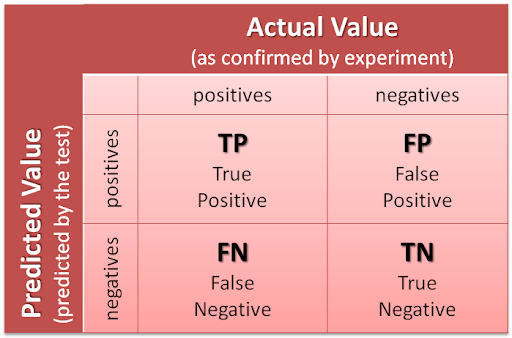
Pour évaluer nos algorithmes , on va s'appuier sur deux métriques:
<ol>
    <li>Exactitude de classification : le nombre de pixels correctement classés sur le nombre total des pixels. Elle est donnée par : $${Exactitude} = ({TP}+{TN})/({TP}+{TN}+{FP}+{FN})$$
    <li>Erreur : le nombre de pixels mal classés sur le nombre total des pixels. Il est donné par : $${Erreur} = ({FP}+{FN})/({TP}+{TN}+{FP}+{FN})$$
</ol>

##### Implémentation:

In [31]:
def perf_measure(y_actual, y_hat):
    y_actual = np.array(y_actual).reshape((-1,1))
    y_hat = np.array(y_hat).reshape((-1,1))
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           tp += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           tp += 1
        elif y_actual[i]==y_hat[i]==0:
           tn += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           fn += 1
    exactitude = (tp+tn)/len(y_hat)
    erreur = (fp+fn)/len(y_hat)
    

    return exactitude, erreur

##### Visualisation des métriques :
Nous avons créé cette fonction qui nous permettera de visualiser nos métriques d'une facon organisée pour qu'on puisse comparer les performances :
pour chaque métrique , la comparaison entre les méthodes peut étre faite par image ainsi que globalement en comparant les moyennes sur le dataset
Le résultat de cette fonction est un objet DataFrame qui montre un tableau comparatif

In [32]:
def show_metrics(verite,m1,m2):
    exactitude_m1 =[]
    erreur_m1 = []
    exactitude_m2 =[] 
    erreur_m2 = []
    for i in range(len(verite)):
        exactitude, erreur = perf_measure(verite[i], m1[i])
        exactitude_m1.append(exactitude)
        erreur_m1.append(erreur)
        ############################################################################""
        exactitude, erreur = perf_measure(verite[i], m2[i])
        exactitude_m2.append(exactitude)
        erreur_m2.append(erreur)
    #############################################################################
    exactitude_m1.append(sum(exactitude_m1)/len(exactitude_m1))
    exactitude_m2.append(sum(exactitude_m2)/len(exactitude_m2))
    #############################################################################
    erreur_m1.append(sum(erreur_m1)/len(erreur_m1))
    erreur_m2.append(sum(erreur_m2)/len(erreur_m2))
    #############################################################################

    image=list(range(1,(len(verite)+1)))
    image.append('mean')
    results = pd.DataFrame({'Image':image ,
                            'exactitude_m1' :exactitude_m1 ,'exactitude_m2' :exactitude_m2,
                            'erreur_m1' :erreur_m1 , 'erreur_m2' :erreur_m2})
    return results
    

## Application des méthodes et des métriques :
### Dossier 1objet :
#### Segmentation :
##### OTSU

In [33]:
objet_otsu = []
for obj in objet :
    img = threshold_otsu(obj)
    objet_otsu.append(img)

##### KNN : 

In [34]:
objet_Knn = []
for obj in objet :
    img = k_means(obj,n_clusters=2)
    objet_Knn.append(img)


#### Visualisation des résultats :

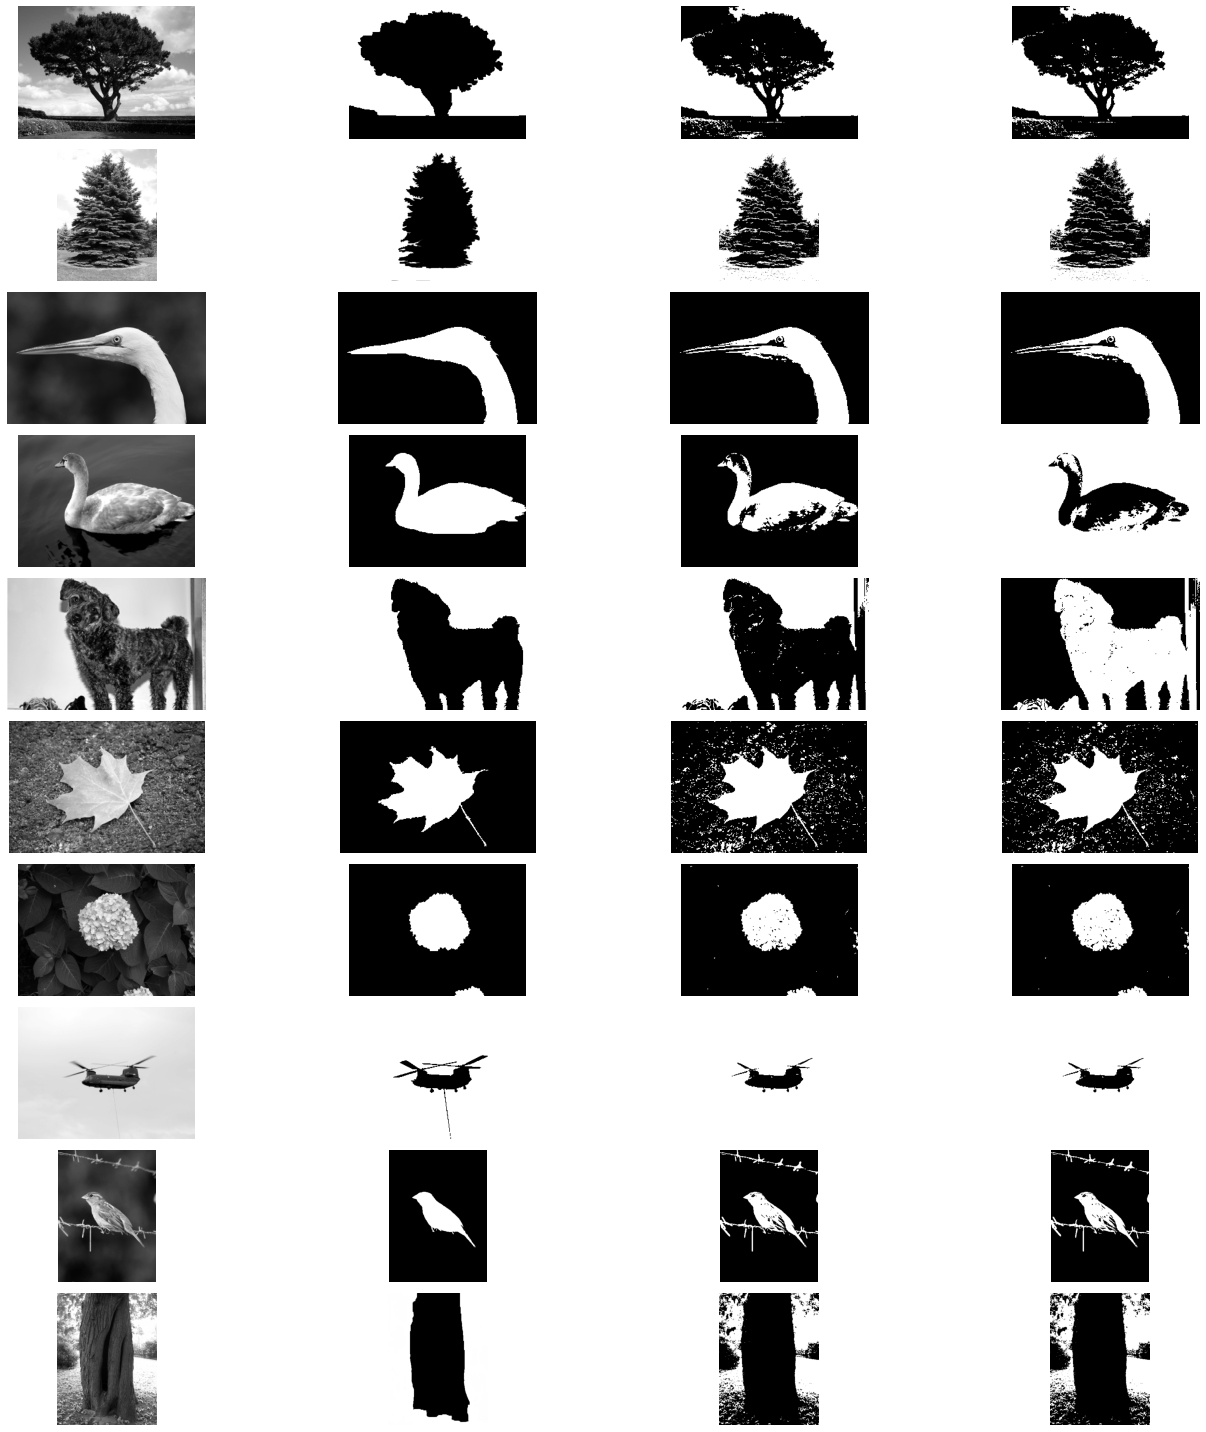

In [35]:
display_after_seg(objet , vobjet , objet_otsu , objet_Knn)

##### Evaluation des performances :

In [36]:
show_metrics(vobjet,objet_otsu,objet_Knn)

Image  exactitude_m1  exactitude_m2  erreur_m1  erreur_m2
0      1       0.945437       0.944563   0.054563   0.055437
1      2       0.939100       0.938183   0.060900   0.061817
2      3       0.970350       0.969817   0.029650   0.030183
3      4       0.933452       0.830637   0.066548   0.169363
4      5       0.941933       0.460000   0.058067   0.540000
5      6       0.999754       0.999672   0.000246   0.000328
6      7       0.996519       0.996222   0.003481   0.003778
7      8       1.000000       1.000000   0.000000   0.000000
8      9       0.990729       0.990303   0.009271   0.009697
9     10       0.782575       0.780008   0.217425   0.219992
10  mean       0.949985       0.890941   0.050015   0.109059

#### Conculsion :
Les deux algorithmes ont donné des résultats trés proches avec une performance un peu plus élevée pour le seuillage OTSU. 

### Dossier 2objets :
#### Segmentation :
##### OTSU

In [37]:
objets_otsu = []
for obj in objets :
    img = threshold_otsu(obj)
    objets_otsu.append(img)

##### KNN

In [38]:
objets_Knn = []
for obj in objets :
    img = k_means(obj,n_clusters=2)
    objets_Knn.append(img)


#### Visualisation des résultats :

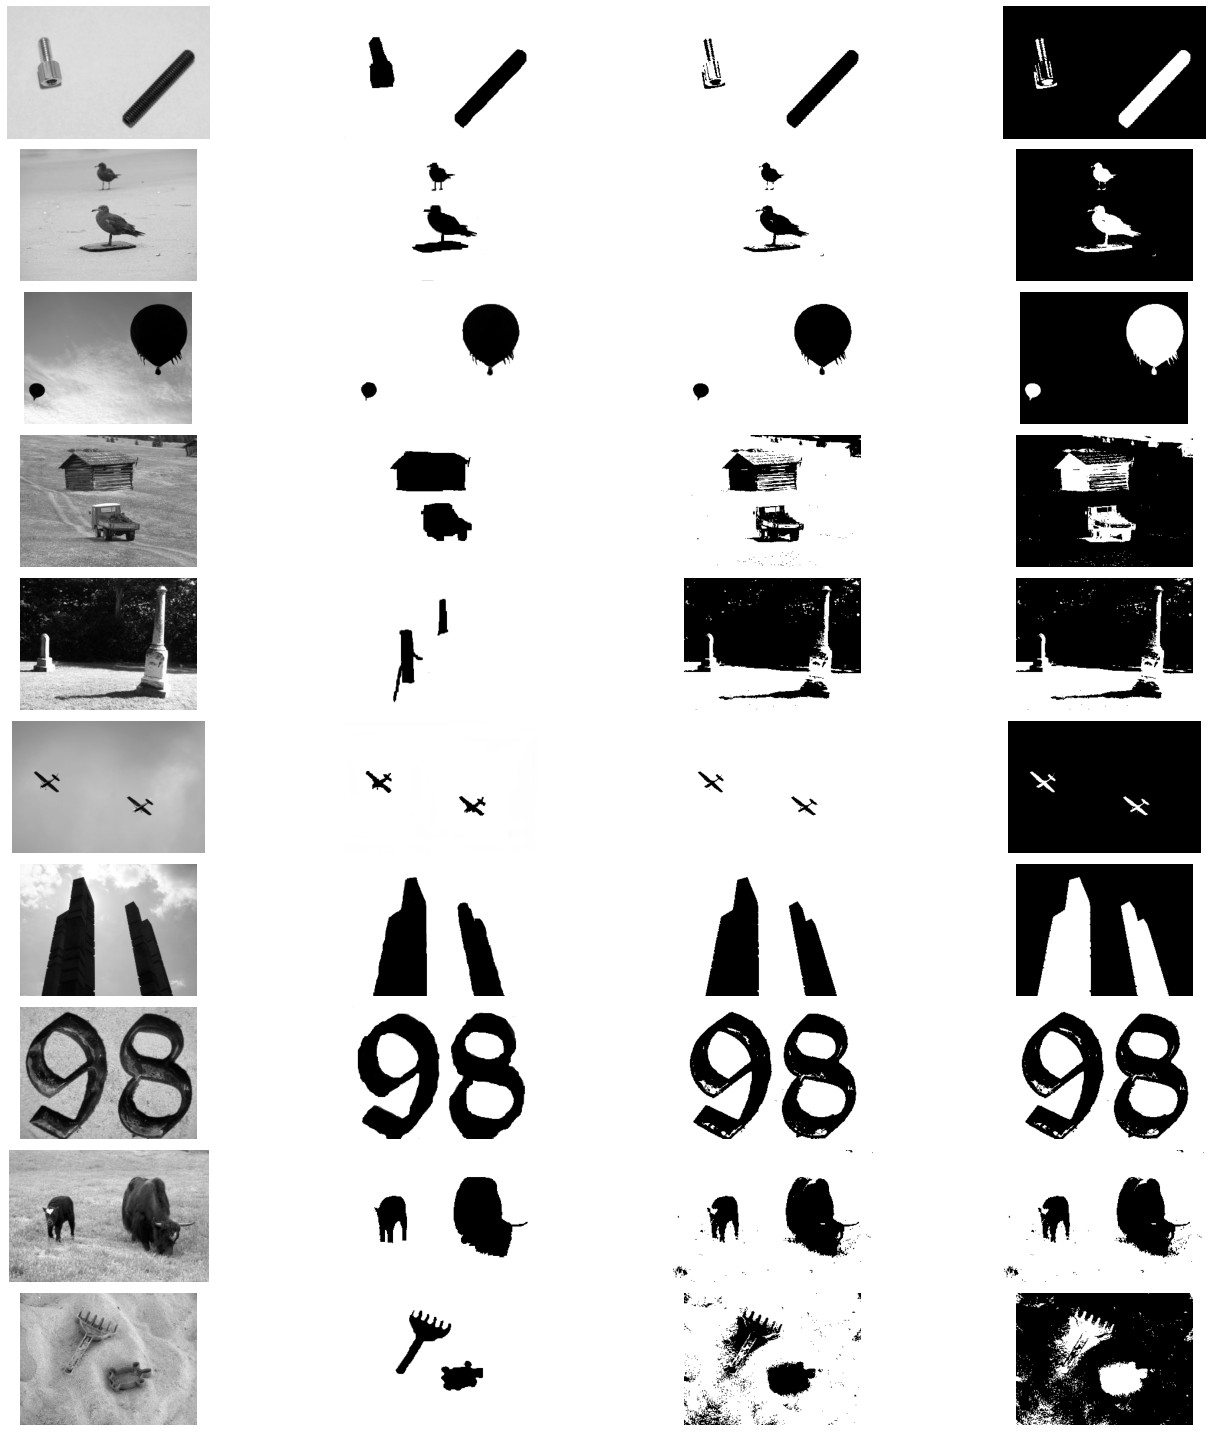

In [39]:
display_after_seg(objets , vobjets , objets_otsu , objets_Knn)

##### Evaluation des performances :

In [40]:
show_metrics(vobjets,objets_otsu,objets_Knn)

Image  exactitude_m1  exactitude_m2  erreur_m1  erreur_m2
0      1       0.998895       0.088248   0.001105   0.911752
1      2       0.998326       0.064489   0.001674   0.935511
2      3       0.924407       0.131893   0.075593   0.868107
3      4       0.952770       0.214889   0.047230   0.785111
4      5       0.346071       0.345283   0.653929   0.654717
5      6       0.999984       0.016165   0.000016   0.983835
6      7       0.995704       0.287481   0.004296   0.712519
7      8       0.973378       0.973200   0.026622   0.026800
8      9       0.994154       0.993702   0.005846   0.006298
9     10       0.911027       0.165804   0.088973   0.834196
10  mean       0.909472       0.328115   0.090528   0.671885

#### Interprétation :
Visuellement , nous trouvons que les deux algorithmes séparent bien les objets sauf que l'algorithme knn échoue à identifer les vrais clusters désigne des valeurs de pixels contraires à ce qui est attendu d'aprés la vérité terrain . Une telle remarque s'illustre bel et bien dans le tableau comparatif qui nous permet de remarquer que les métriques de otsu sont meilleures que celles de KNN.
#### Conclusion :
Les deux algorithmes réussissent la tache de segmentation mais en revenant à la verité terrain , on trouve que OTSU est plus performant

### Dossier cellules :
#### Segmentation :
Pour ce dataset , on trouve que la vérité terrain n'est pas binaire mais il existe plutot 3 classes principales : le noir , le blanc et le gris : on vas donc donc faire la segmentation avec 3 classes.<br>
NB : on pouvait aussi nous servir du seuillage adptatif
##### OTSU

In [41]:
cellules_otsu = []
for cellule in cellules :
    img = threshold_multi_otsu(cellule , classes=3)
    cellules_otsu.append(img)

##### KNN

In [42]:
cellules_Knn = []
for cellule in cellules :
    img = k_means(cellule,n_clusters=3)
    cellules_Knn.append(img)


#### Visualisation des résultats :

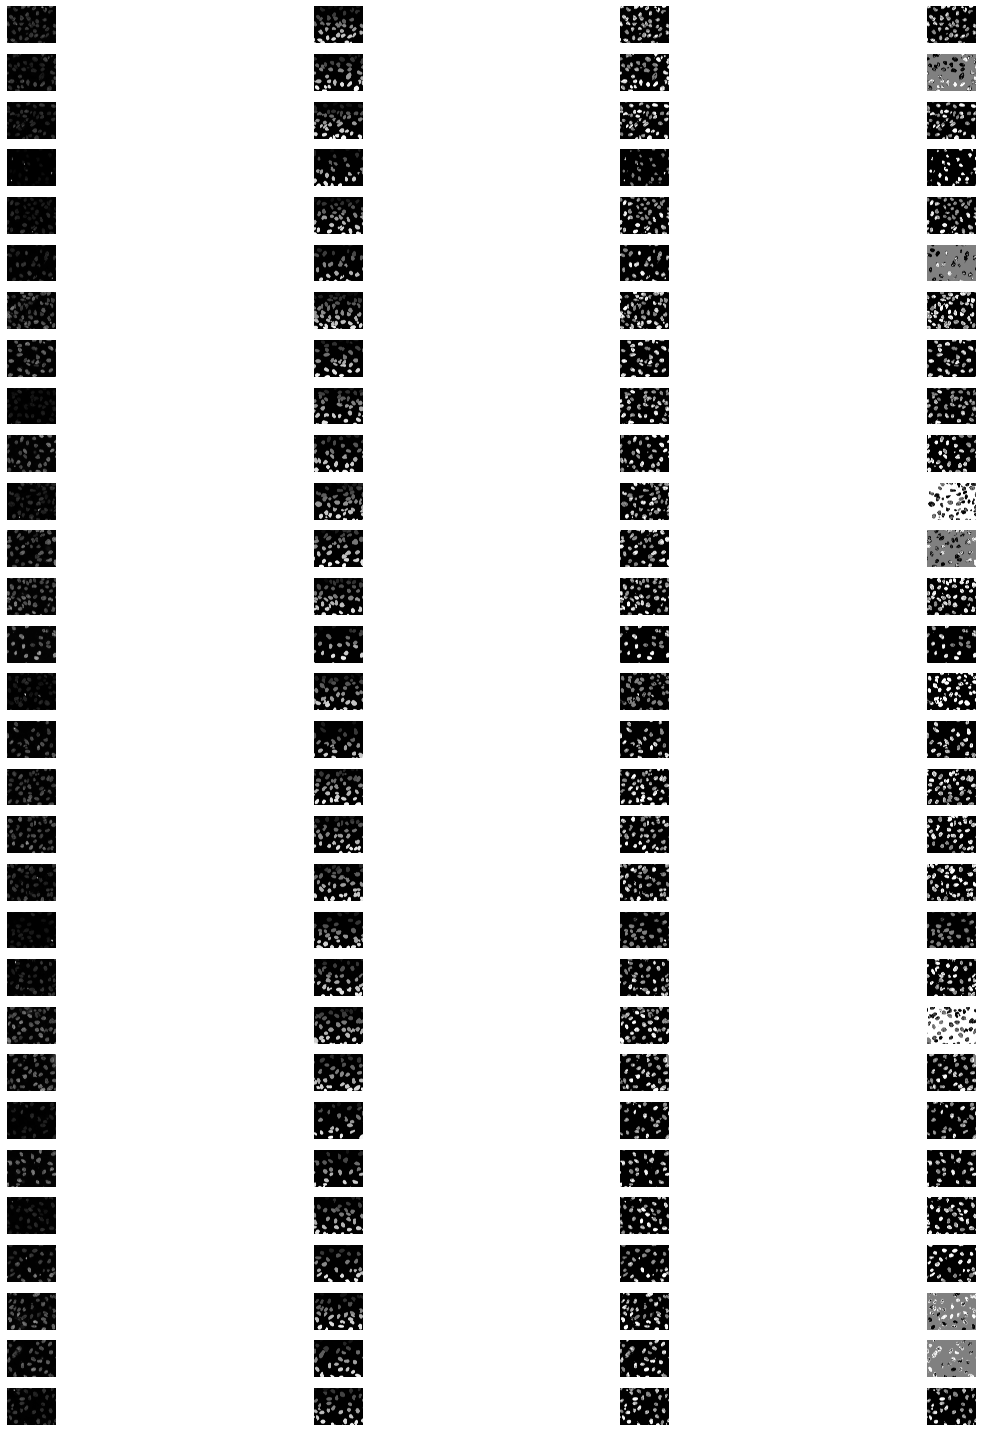

In [43]:
display_after_seg(cellules , vcellules , cellules_otsu , cellules_Knn)

##### Evaluation des performances :
###### Attention : L'execution de cette cellule peut prendre du temps cas il existe plus d'images que dans les autres dossiers et car l'operation de seuillage est un peut complexe 

In [44]:
show_metrics(vcellules , cellules_otsu , cellules_Knn)

Image  exactitude_m1  exactitude_m2  erreur_m1  erreur_m2
0      1       0.898014       0.903017   0.015694   0.017806
1      2       0.887525       0.753869   0.012249   0.155616
2      3       0.864193       0.870517   0.023757   0.026922
3      4       0.914059       0.828500   0.082277   0.069925
4      5       0.897101       0.893636   0.018832   0.022297
5      6       0.937555       0.831126   0.012182   0.123101
6      7       0.850791       0.769742   0.030801   0.033072
7      8       0.879224       0.883774   0.018193   0.018193
8      9       0.877692       0.905819   0.029506   0.035277
9     10       0.893754       0.843860   0.022555   0.022555
10    11       0.867522       0.092186   0.051481   0.174334
11    12       0.877058       0.754920   0.024162   0.156150
12    13       0.880601       0.786819   0.020106   0.020106
13    14       0.927130       0.928801   0.014832   0.015877
14    15       0.949164       0.713455   0.048760   0.048760
15    16       0.919344       0.881954   0.017837   0.017837
16    17       0.858668       0.824927   0.022393   0.024535
17    18       0.894086       0.820642   0.026306   0.026306
18    19       0.884664       0.790267   0.028070   0.028070
19    20       0.947109       0.947109   0.051401   0.051401
20    21       0.911899       0.830272   0.030012   0.026879
21    22       0.852935       0.132797   0.031017   0.149424
22    23       0.882906       0.890262   0.026002   0.026002
23    24       0.943635       0.949589   0.006816   0.008365
24    25       0.922731       0.922239   0.010748   0.011240
25    26       0.892997       0.828630   0.025775   0.029624
26    27       0.930636       0.851369   0.023782   0.023782
27    28       0.879486       0.765366   0.023769   0.096042
28    29       0.903561       0.816656   0.014690   0.068511
29    30       0.897690       0.906427   0.020993   0.022916
30  mean       0.897458       0.797285   0.026167   0.051697

#### Conculsion :
La méthode KNN échoue gravement pour certaines images : en global la méthode otsu multiclasse est plus efficace

### Dossier textfort :
#### Segmentation :
##### OTSU

In [45]:
text_otsu = []
for obj in textfort :
    img = threshold_otsu(obj)
    text_otsu.append(img)
    


##### KNN

In [46]:
text_Knn = []
for obj in textfort :
    img = k_means(obj,n_clusters=2)
    text_Knn.append(img)


#### Visualisation des résultats :

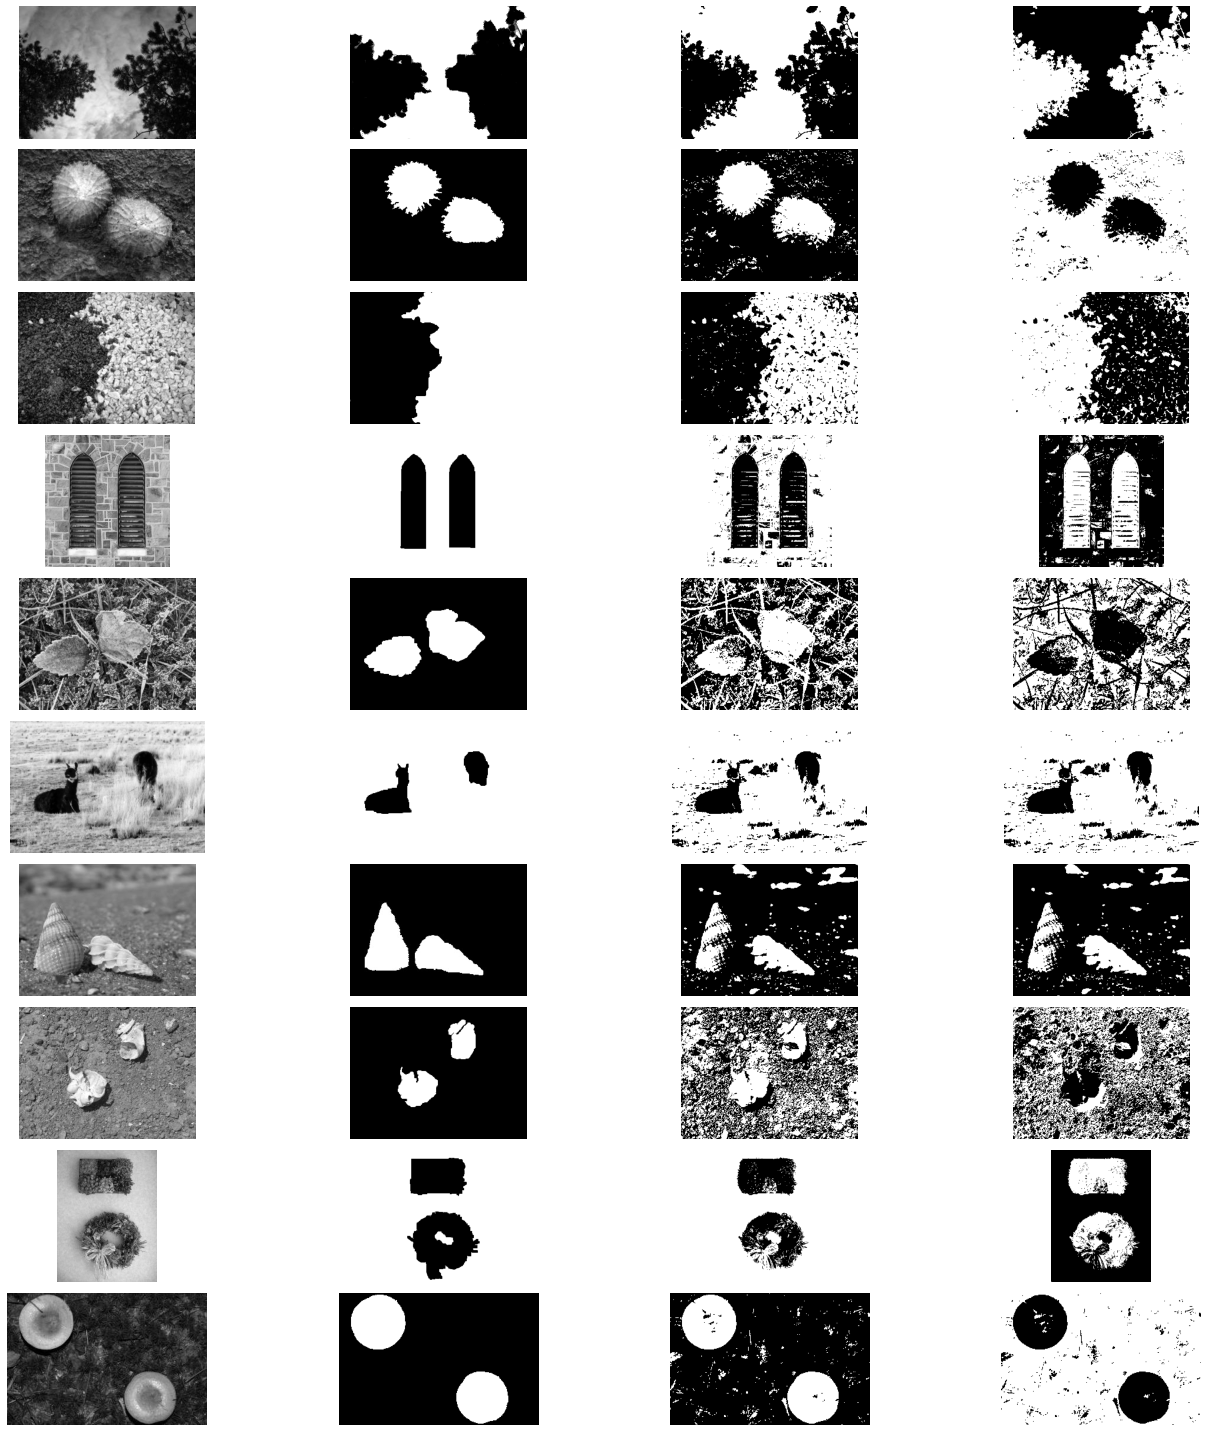

In [47]:
display_after_seg(textfort , vtextfort , text_otsu , text_Knn)

##### Evaluation des performances :

In [48]:
show_metrics(vobjet,objet_otsu,objet_Knn)

Image  exactitude_m1  exactitude_m2  erreur_m1  erreur_m2
0      1       0.945437       0.944563   0.054563   0.055437
1      2       0.939100       0.938183   0.060900   0.061817
2      3       0.970350       0.969817   0.029650   0.030183
3      4       0.933452       0.830637   0.066548   0.169363
4      5       0.941933       0.460000   0.058067   0.540000
5      6       0.999754       0.999672   0.000246   0.000328
6      7       0.996519       0.996222   0.003481   0.003778
7      8       1.000000       1.000000   0.000000   0.000000
8      9       0.990729       0.990303   0.009271   0.009697
9     10       0.782575       0.780008   0.217425   0.219992
10  mean       0.949985       0.890941   0.050015   0.109059

#### Interprétation :
Visuellement , nous trouvons que les deux algorithmes séparent bien les objets sauf que l'algorithme knn échoue à identifer les vrais clusters désigne des valeurs de pixels contraires à ce qui est attendu d'aprés la vérité terrain . Une telle remarque s'illustre bel et bien dans le tableau comparatif qui nous permet de remarquer que les métriques de otsu sont meilleures que celles de KNN.
#### Conclusion :
Les deux algorithmes réussissent la tache de segmentation mais en revenant à la verité terrain , on trouve que OTSU est plus performant

### Conclusion Générale :
Pour l'ensemble des bases d'images , la méthode otsu est plus performante , mais cela ne veut pas dire que la méthode KNN n'a pas réussi à segmenter .En effet les sorties de cet algorithme montre que nous pouvons distinguer les objets a segmenter . Les faiblesses donc sont dues au fait que KNN est :
* Sensible aux minima locaux, donc à l’initialisation
* Sensible aux valeurs aberrantes
<br>
Les résultats de knn pouvaient étre mieux que ca si on change quelques paramétres dans la méthode qui l'impémente comme le random state (fixé à 42).<br>
il est important de mentionner que le knn prend plus de temps pour étre executé par rapport à otsu.<br>